In [3]:
import matplotlib.pyplot as plt
import numpy as np

**intro + NumPy**

In this lab we will implement the forward pass of a neural network. We will rely heavily on NumPy -- a Python package for efficienct processing of array data.

To get started with this, here is an implementation of a function that computes the sigmoid activation function using NumPy to help us compute the exponential. 

In [4]:
def sigmoid(z):
  '''
  Sigmoid activation function

  parameters:
  - z (array): input to the activation function
  '''
  return 1 / (1 + np.exp(-np.array(z)))

One great thing about using NumPy is that often times we can write code that looks like it operates on a single number, but NumPy will also work on its own `ndarray` array objects (nd = 'n-dimensional') as well as lists (which it will convert to arrays for you.

Try it out before. Use this function to compute the output of the sigmoid activation function for the input value 0.0 by itself, and then also for the values (-2.0, -1.0, 0.0, 1.0, 2.0) at the same time with only one call to the function.

In [ ]:
# your code here
sigmoid(0)


0.5

In [ ]:
sigmoid([-2.0, -1.0, 0.0, 1.0, 2.0])

array([0.11920292, 0.26894142, 0.5       , 0.73105858, 0.88079708])

**single neuron**

As a warm-up for implementing a full neural network layer, let's implement the computation performed by a single neuron.

If our neuron has $m$ inputs, then its output will be defined by:

- the inputs, which we can represent as an $m$-dimensional array: $x=[x_1, x_2, ..., x_m]$
- the weights for each input, which we can represent as another $m$-dimensional vector: $w = [w_1, w_2, ..., w_n]$
- the bias, which is a scalar: $b$

Use the sigmoid activation function -- $\sigma(z)$ -- for this neuron.

With these definitions, the output of our neuron is:
$$a = \sigma(w_1 x_1 + w_2 x_2 + ... + w_m x_m + b)$$
$$=\sigma(w \cdot x + b)$$

In [5]:
def neuron(x, w, b):
  '''
  tranformation for a single layer of a neural network

  parameters
  ----------
  x (1d array): input vector
  w (1d array): neuron weights
  b (float):    bias
  '''
  
  # remove the `pass` and add your code that returns the correct result
  z = 0
  for i in range(len(x)):
    z+= x[i] * w[i]
  z += b
  return sigmoid(z)

Here are some tests that should pass if your implementation is correct.

In [6]:
np.testing.assert_equal(
    neuron([0, 0, 0], [0, 0, 0], 0),
    0.5
)
np.testing.assert_equal(
    neuron([0, 0, 0], [0, 0, 0], 1),
    1 / (1 + np.exp(-1))
)
np.testing.assert_equal(
    neuron([1, 0, 1], [0, 1, 0], 0),
    0.5
)
np.testing.assert_equal(
    neuron([1, -1, 0], [2, 1, 0], -1),
    0.5
)

**vectorizing**

If your code for a single neuron used a loop, you had the right idea! However, in languages with Python, which are not built for speed, writing your own loops can be slow. Right now, your code probably doesn't feel very slow, but once we start to fit your neural net to data, you will need to call this function many times (easily millions of times, if not more!).

For critical portions of your code like this, it can be worth the extra work to *vectorize* your code. This means rewriting your code to use a package like NumPy that can compute the result you want directly from vectors/arrays, allowing NumPy to do the looping under the hood for you. The benefit here is that NumPy's has critical loops written in lower level languages (like C, C++, or FORTRAN) where loops are faster (though the code is harder to write and make sure it is correct).

Go back and try to write a vectorized version of the `neuron` function using helper functions from NumPy that let you avoid writing a loop. Hint: check out the NumPy's `np.dot` function.

In [7]:
# vectorized version
def neuron(x, w, b):
  '''
  tranformation for a single layer of a neural network

  parameters
  ----------
  x (1d array): input vector
  w (1d array): neuron weights
  b (float):    bias
  '''
  return sigmoid(np.dot(x,w) +b)

Try the tests again to make sure it still works.

In [8]:
np.testing.assert_equal(
    neuron([0, 0, 0], [0, 0, 0], 0),
    0.5
)
np.testing.assert_equal(
    neuron([0, 0, 0], [0, 0, 0], 1),
    1 / (1 + np.exp(-1))
)
np.testing.assert_equal(
    neuron([1, 0, 1], [0, 1, 0], 0),
    0.5
)
np.testing.assert_equal(
    neuron([1, -1, 0], [2, 1, 0], -1),
    0.5
)

**neural net layer with batch inputs**

Now for the real deal: extending our function for a single neuron in two ways:
- first, so that it can process a "batch" of multiple inputs rather than just a single input
- second, so that it can do the computation for an entire hidden layer of neurons instead of just one

Let's look at the math for each of these extensions in turn.

*batch inputs*:

We want to process a set (or "batch") of inputs at the same time, both for the sake of convenience and so we can hopefully vectorize the code to make processing a batch faster than simply looping through all of the inputs in the batch.

If we have $k$ inputs in a batch, each of which are $m$-dimensional, then we can organize these inputs into a $k$-by-$m$ matrix simply by stacking the individual input vectors:

\\
$$
\begin{bmatrix}
  -\, x^1 \, -\\
  -\, x^2 \, -\\
  \vdots \\
  -\, x^k \, -\\
\end{bmatrix}
=
\begin{bmatrix}
x_{11} & x_{12} & \cdots & x_{1m} \\
x_{21} & x_{22} & \cdots & x_{2m} \\
\vdots & \vdots  &  \ddots & \vdots \\
x_{k1} & x_{k2} & \cdots & x_{km}
\end{bmatrix}
$$

\\
where each row contains the components for one input

*multiple neurons*

Now let's considering an entire layer of neurons that recieve this same input and, again, we want to compute the outputs for the entire layer together for convenience and efficiency.

If we have $n$ neurons, we will now have $m$ of weights (for a  $m$-dimensional input) for each neuron. Similar to what we just saw for extending to multiple inputs, we can collect these weights in an $m$-by-$n$ matrix, but this times lets put each weight vector in its own column (we'll see why shortly):

\\
$$W =
\begin{bmatrix}
| & | & \quad & | \\
w^1 & w^2 & \cdots & w^n \\
| & | & \quad & |
\end{bmatrix}
=
\begin{bmatrix}
w_{11} & w_{12} & \cdots & w_{1n} \\
w_{21} & w_{22} & \cdots & w_{2n} \\
\vdots & \vdots & \ddots & \vdots \\
w_{m1} & w_{m2} & \cdots & w_{mn}
\end{bmatrix}
$$

\\
where each column contains the weights for one of the neurons in the layer. We also have one bias for each neuron, which we can organize in a vector:

\\
$$
b =
\begin{bmatrix}
b_1 & b_2 & \cdots & b_n
\end{bmatrix}
$$.

\\
*putting it all together*

Next, we want to compute the total weighted input to each neuron in the layer for each input. We can organize these values into a matrix, with one row for each sample and one column for each neuron in our layer. 

\\
$$
\begin{bmatrix}
x^1 \cdot w^1 & x^1 \cdot w^2 & \cdots & x^1 \cdot w^n \\
x^2 \cdot w^1 & x^2 \cdot w^2 & \cdots & x^2 \cdot x^n \\
\vdots & \vdots & \ddots & \vdots \\
x^m \cdot w^1 & x^m \cdot w^2 & \cdots & x^m \cdot w^n
\end{bmatrix}
$$

\\
But taking the dot product between all rows of one matrix with all columns of another matrix is exactly the definition of matrix multiplication, so we have:

\\
$$
\begin{bmatrix}
x^1 \cdot w^1 & x^1 \cdot w^2 & \cdots & x^1 \cdot w^n \\
x^2 \cdot w^1 & x^2 \cdot w^2 & \cdots & x^2 \cdot x^n \\
\vdots & \vdots & \ddots & \vdots \\
x^m \cdot w^1 & x^m \cdot w^2 & \cdots & x^m \cdot w^n
\end{bmatrix}
=
\begin{bmatrix}
  -\, x^1 \, -\\
  -\, x^2 \, -\\
  \vdots \\
  -\, x^k \, -\\
\end{bmatrix} 
\begin{bmatrix}
| & | & \quad & | \\
w^1 & w^2 & \cdots & w^n \\
| & | & \quad & |
\end{bmatrix}
=XW
$$

\\
We also need to add the bias terms, which is the same for each row/neuron. We can write this as:

\\
$$
\begin{bmatrix}
x^1 \cdot w^1 + b_1 & x^1 \cdot w^2 + b_2 & \cdots & x^1 \cdot w^n + b_n \\
x^2 \cdot w^1 + b_1 & x^2 \cdot w^2 + b_2 & \cdots & x^2 \cdot x^n + b_n \\
\vdots & \vdots & \ddots & \vdots \\
x^m \cdot w^1 + b_1 & x^2 \cdot w^2 + b_2 & \cdots & x^m \cdot w^n + b_n
\end{bmatrix} \\
=
\begin{bmatrix}
x^1 \cdot w^1 & x^1 \cdot w^2 & \cdots & x^1 \cdot w^n \\
x^2 \cdot w^1 & x^2 \cdot w^2 & \cdots & x^2 \cdot x^n \\
\vdots & \vdots & \ddots & \vdots \\
x^m \cdot w^1 & x^m \cdot w^2 & \cdots & x^m \cdot w^n
\end{bmatrix}
+
\begin{bmatrix}
b_1 & b_2 & \cdots & b_m
\end{bmatrix}
= XW + b
$$

\\
where when have have addition of a matrix to a row/column vector, we interpret this via *broadcasting*: we assume that the row/column is repeated across all rows/columns to match the shape of the matrix. This is exactly how many numeric programming langauges/packages (including NumPy) handle this as well.

Finally, the outputs for all neurons across all batches can be computed by applying the activation function elementwise for a final result of:

\\
$$
A = \sigma(XW + b)
$$

\\
And here is the best part: the same function in NumPy that computes the dot-product between two 1-dimensional arrays also computes matrix multiplication when given 2-dimensional arrays instead. This means that the function you wrote for a single neuron will already work for multiple neurons across a batch of inputs!

Go ahead and try it -- simply change the weights and inputs to 2d-arrays (and you can change the biases to a 1d-array if you want a different bias for each neuron.

In [9]:
def nn_layer(X, W, b):
  '''
  tranformation for a single layer of a neural network

  parameters
  ----------
  X (2d array): input vectors
  W (2d array): neuron weights
  b (1d array): biases
  '''
  return sigmoid(np.dot(X,W)+b)


Again, here are some tests to see if your network is probably handling multiple inputs and multiple outputs.

In [10]:
X = [
     [0, 0, 0],
     [1, 1, 1],
     [-1, 0, 1]
]
W = [
     [0, 1, 0],
     [0, 1, 1],
     [0, 1, 2]
]
b = [0, 0, 0]
A = nn_layer(X, W, b)
np.testing.assert_array_equal(A, [[0.5, 0.5, 0.5], [0.5, sigmoid(3), sigmoid(3)], [0.5, 0.5, sigmoid(2)]])

b = [[1, 2, 3]]
A = nn_layer(X, W, b)
np.testing.assert_array_equal(A, [[sigmoid(1), sigmoid(2), sigmoid(3)], [sigmoid(1), sigmoid(5), sigmoid(6)], [sigmoid(1), sigmoid(2), sigmoid(5)]])

**neural net with one hidden layer**

Next, let's make a function to implement a two-layer neural network - one hidden layer and the output layer. It should takes as inputs:
- An input matrix, $X$
- Two weight matrices, $W_1$ and $W_2$ (one for each layer)
- Two bias vectors, $b_1$ and $b_2$ (one for each layer)

This function should call your `nn_layer` function twice with the appropriate arguments, chaining the output of the first layer into the input to the secocond layer, and then returning the final output

In [11]:
def nn_two_layers(X, W_1, b_1, W_2, b_2):
  '''
  forward pass of a two-layer neural network

  parameters
  ----------
  X (2d array):   input matrix
  W_1 (2d array): weight matrix for first layer
  b_1 (1d array): biases for first layer
  W_2 (2d array): weight matrix for second layer
  b_2 (1darray):  biases for second layer
  '''
  H = nn_layer(X, W_1 , b_1)
  Y = nn_layer(H, W_2 , b_2)
  return Y

To test out your brand new neral net function, let's test it out on a 1-dimensional input and a 1-dimensional output so that we can plot the results with a line graph. We will use random values for the weight and biases.

Follow along below as we walk through how to do this with some NumPy functions and Python's popular plotting package, Matplotlib.

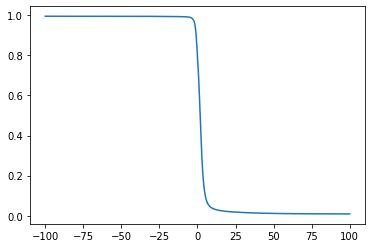

In [73]:
# Set the input dimension, the number of hidden units, and the number of ouptput units
n_input, n_hidden, n_output = 1, 20, 1

# We want get the NN's output for a range of input values, so that we cant plot
# input vs output. We can get evenly space values using `np.linspace`. We also
# want to process these inputs as a "batch", so we use `np.newaxis` to turn this
# 1-d array into a 2-d array with a single column.
n_grid = 1000
x_left, x_right = -100, 100
X = np.linspace(x_left, x_right, n_grid)[:, np.newaxis]

# We can generate random values (drawn from a standard gaussian distribution --
# mean = 0, standard deviation = 1), with `np.random.randn(shape)`
W_1 = np.random.randn(n_input, n_hidden)
b_1 = np.random.randn(n_hidden)
W_2 = np.random.randn(n_hidden, n_output)
b_2 = np.random.randn(n_output)

# Use our NN to compute the outputs for these inputs
Y_hat = nn_two_layers(X, W_1, b_1, W_2, b_2)

# Plot the input values (x-axis) against the output values (y-axis)
plt.plot(X, Y_hat)
plt.show()

### Exercises

**function exploration**

Use your code for the 2-layer neural network to explore how the number of neruons in the hidden layer affects the function that the neural network implements. Vary the number of hidden neurons between say 1 and 20 and look at a few example networks for each. Plot some results for various values.

How does the number of hidden units effect the function that your neural net represents? Explain why this is is this?

What range of outputs seems to be acheivable? Why is this? What kind of supervised learning task would this network be suited for because of this?

Type your answer in a text box below.

***How does the number of hidden units effect the function that your neural net represents? Explain why this is is this?***
The number of hidden units effect the accuracy of the neural net model. More the hidden units more accuracy of the model. This is because more units calculate weighted sum of inputs and weights, add the bias.

***What range of outputs seems to be acheivable? Why is this? What kind of supervised learning task would this network be suited for because of this?***
The range seems to be [0,1] and this is because this function is based on sigmoid activation function. This network would be suited for classification problem (ex; classify if the image is dog, cat, or fish) because of this.

**deep neural nets**

Our neural network currently works for only a single hidden layer. This is a rather shallow network, and the next step is to extend it to a deep network that can handle any number of layers.

To handle an arbitrary number of layers, switch to taking a 3-dimensional array for the layer weights -- now the first index will specify which layer the remaing 2-dimension subarray is associated with (e.g. `W[2]` would be the 2-d array of weights for the connections from layer 2 to layer 3). Similary, add another dimension to the biases to specify the layer, making $b$ a 2-dimensional array.

Here you will probably need to use a for loop to iterate through the layers. You can continue to use the sigmoid activation function for all layers.

In [75]:
def deep_nn(X, W, b):
  '''
  forward pass for a deep neural net with an arbitrary number of layers

  parameters
  ----------
  X (2d array):     input vectors
  W (3d array):     weight matrices -- W[layer, input, neuron]
  b (2d array):     biase vectors -- b[layer, neuron]
  '''
  z = 0
  for i in range(len(X)):
    z+= nn_layer(X,W,b)
  return z